# 1.Data Loading and Conversion

In [1]:
import numpy as np
x = np.load('./AtlasGNNinput/AAL_correlation_correlation.npy')  # Shape
y = np.load('./AtlasGNNinput/Y.npy')  # Assuming shape: (871,)

print(x.shape)
print(y.shape)

(871, 116, 116)
(871,)


# 2. Graph Arrangement

In [2]:
num_graphs, num_nodes, _ = x.shape
print(x.shape)
num_features = num_nodes * (num_nodes - 1) // 2   

print("num_graphs:", num_graphs)   
print("num_nodes:", num_nodes)    
print("num_features:", num_features)  

# Build a list mapping each “feature index” [0..E] → an (i,j) pair in the upper triangle
edge_pairs = [(i, j) for i in range(num_nodes) for j in range(i + 1, num_nodes)]
# Now edge_pairs[k] gives the (i,j) for that k in [0..num_features-1]

(871, 116, 116)
num_graphs: 871
num_nodes: 116
num_features: 6670


# 3. Parameter for trials and selection

In [3]:
num_selected = int(0.20 * num_features)  # 20% of 6670= 1334 indices
num_trials = 500  # number of repetitions.
num_epochs = 30  # number of training epochs per trial. \

# Create arrays to store each trial's selected indices and accuracy.
# The indices array is shaped as (num_selected, num_trials), where each column represents one trial.
indices_matrix = np.zeros((num_selected, num_trials), dtype=int)
accuracy_vector = np.zeros(num_trials)

# 4. Generate Graph Function

In [4]:
import torch
from torch_geometric.data import Data

def generate_multiple_graphs(X, y):
    """
    Generate multiple PyTorch Geometric graph objects from full symmetric adjacency matrices.
    
    Parameters:
        X (numpy.ndarray): 3D array of shape (num_graphs, N_nodes, N_nodes) where each entry is an adjacency matrix.
        y (numpy.ndarray): 1D array of graph labels.
    
    Returns:
        List[Data]: A list of PyTorch Geometric Data objects.
    """
    graphs = []
    num_graphs = X.shape[0]
    N_nodes = X.shape[1] # Assuming square adjacency matrices

    for graph_idx in range(num_graphs):
        adjacency_matrix = X[graph_idx]
        label = y[graph_idx]

        # Initialize node features,edge index and weight.
        node_features = [[1,] for _ in range(N_nodes)]
        edge_index = []
        edge_weight = []

        # Iterate over upper triangle to avoid self-loops and duplicate edges
        for i in range(N_nodes):
            for j in range(i + 1, N_nodes): # Avoiding self-loops and duplicate edges
                weight = adjacency_matrix[i, j]
                if weight != 0: # Only include edges with non-zero weight
                    # Add both (i, j) and (j, i) for undirected graph
                    edge_index.append([i, j])
                    edge_weight.append(weight) # I removed the additional edge_index since the graph is undirected. 
                                       
                    # Update node features by accumulating connected edge weights
                    node_features[i][0] += weight
                    node_features[j][0] += weight

        # Convert lists to PyTorch tensors
        if edge_index:
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
            edge_weight = torch.tensor(edge_weight, dtype=torch.float)
        else:
            edge_index = torch.empty((2, 0), dtype=torch.long)
            edge_weight = torch.tensor([], dtype=torch.float)
        node_features = torch.tensor(node_features, dtype=torch.float)
        label_tensor = torch.tensor(label, dtype=torch.float)

        data = Data(x=node_features, edge_index=edge_index, edge_weight=edge_weight, y=label_tensor)
        graphs.append(data)
                     
    return graphs

# 5. GNN Model

In [5]:
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool

class GraphAttentionModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super(GraphAttentionModel, self).__init__()
        # 1st GATv2 layer: input_dim → hidden_dim, using 'heads' attention heads
        # edge_dim=1 since each edge has one feature (FC weight)
        self.gat1 = GATv2Conv(
            in_channels=input_dim,
            out_channels=hidden_dim,
            heads=heads,
            dropout=0.3,
            edge_dim=1
        )
        # 2nd GATv2 layer: (hidden_dim * heads) → hidden_dim
        self.gat2 = GATv2Conv(
            in_channels=hidden_dim * heads,
            out_channels=hidden_dim,
            heads=heads,
            dropout=0.3,
            edge_dim=1
        )
        # 3rd GATv2 layer: (hidden_dim * heads) → output_dim, single head, no concat
        self.gat3 = GATv2Conv(
            in_channels=hidden_dim * heads,
            out_channels=output_dim,
            heads=1,
            concat=False,
            dropout=0.3,
            edge_dim=1
        )
        # Final linear layer for binary classification
        self.fc = torch.nn.Linear(output_dim, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        # Reshape edge_weight from (E,) → (E, 1)
        ew = edge_weight.view(-1, 1)

        # 1) Apply first GATv2 + ReLU
        x = F.relu(self.gat1(x, edge_index, ew))
        # 2) Apply second GATv2 + ReLU
        x = F.relu(self.gat2(x, edge_index, ew))
        # 3) Apply third GATv2 (no activation)
        x = self.gat3(x, edge_index, ew)
        # 4) Global mean pool over nodes → one graph vector
        x = global_mean_pool(x, batch)
        # 5) Linear layer + sigmoid for binary output
        x = self.fc(x)
        return torch.sigmoid(x)

# 6. Training and Evaluation Functions

In [6]:
def train(model, loader, optimizer, criterion):
    # Train the model for one epoch over the given data loader
    model.train()
    total_loss = 0

    for data in loader:
        optimizer.zero_grad()
        # Forward pass
        out = model(data.x, data.edge_index, data.edge_weight, data.batch)
        # Compute loss (reshape output to match labels)
        loss = criterion(out.squeeze(1), data.y.float())
        # Backward pass and weight update
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Return the average loss per batch
    return total_loss / len(loader)


def evaluate(model, loader):
    # Compute overall accuracy of the model on the provided data loader
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in loader:
            # Forward pass
            out = model(data.x, data.edge_index, data.edge_weight, data.batch)
            # Convert probabilities to binary predictions (threshold = 0.5)
            pred = (out.squeeze(1) > 0.5).float()
            correct += (pred == data.y).sum().item()
            total += data.num_graphs

    # Return the fraction of correctly classified graphs
    return correct / total


def eval_loss(model, loader, criterion):
    # Compute the average loss of the model over all graphs in the loader
    model.eval()
    total_loss = 0.0
    total_graphs = 0

    with torch.no_grad():
        for data in loader:
            # Forward pass
            out = model(data.x, data.edge_index, data.edge_weight, data.batch)
            # Compute loss for this batch, weighted by number of graphs
            loss = criterion(out.squeeze(1), data.y.float())
            total_loss += loss.item() * data.num_graphs
            total_graphs += data.num_graphs

    # Return the average loss per graph
    return total_loss / total_graphs

# 7. Main Loop: Trails of random column removal, train/test split and graph generation/classiication

In [7]:
from torch_geometric.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import random_split

for trial in range(num_trials):
    print(f"Trial {trial+1}/{num_trials}")

    # 1) Randomly select 20% of the 6670 upper‐triangle “features” (each maps to one (i,j) pair)
    selected_feat_idxs = np.random.choice(num_features, size=num_selected, replace=False)
    indices_matrix[:, trial] = selected_feat_idxs  # Save selected indices for this trial

    # 2) Create a modified copy of the full (871, 116, 116) FC matrices
    X_mod = x.copy()  # x.shape 

    #    Zero out each chosen edge (i,j) and its mirror (j,i) across all subjects
    for feat_idx in selected_feat_idxs:
        i, j = edge_pairs[feat_idx]
        X_mod[:, i, j] = 0.0
        X_mod[:, j, i] = 0.0

    # 3) Generate PyG graphs from the masked FC matrices
    graphs = generate_multiple_graphs(X_mod, y)

    # 4) Split graphs into train/val/test (80/10/10)
    dataset_size = len(graphs)
    train_size   = int(0.8 * dataset_size)
    val_size     = int(0.1 * dataset_size)
    test_size    = dataset_size - train_size - val_size
    train_data, val_data, test_data = random_split(graphs, [train_size, val_size, test_size])

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_data,   batch_size=32)
    test_loader  = DataLoader(test_data,  batch_size=32)

    # 5) Initialize model, loss, optimizer, and scheduler
    model     = GraphAttentionModel(input_dim=1, hidden_dim=16, output_dim=2)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # 6) Training loop 
    best_val_loss    = float('inf')
    best_model_state = None
    wait             = 0
    patience         = 10

    for epoch in range(1, num_epochs + 1):
        train_loss = train(model, train_loader, optimizer, criterion)
        val_loss   = eval_loss(model, val_loader, criterion)
        val_acc    = evaluate(model, val_loader)
        scheduler.step(val_loss)

        print(f"Epoch {epoch:02d} — Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss    = val_loss
            best_model_state = model.state_dict()
            wait             = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"--> Early stopping at epoch {epoch} (no val_loss improvement in {patience} epochs)")
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # 7) Test‐set evaluation
    test_acc = evaluate(model, test_loader)
    accuracy_vector[trial] = test_acc
    print(f"Trial {trial+1} Test Acc: {test_acc:.4f}")

Trial 1/500


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch 01 — Train Loss: 4.0390, Val Loss: 2.0707, Val Acc: 0.4828
Epoch 02 — Train Loss: 2.5836, Val Loss: 1.3906, Val Acc: 0.4828
Epoch 03 — Train Loss: 1.6186, Val Loss: 0.8833, Val Acc: 0.4828
Epoch 04 — Train Loss: 1.0740, Val Loss: 0.6931, Val Acc: 0.5287
Epoch 05 — Train Loss: 0.7940, Val Loss: 0.7313, Val Acc: 0.5172
Epoch 06 — Train Loss: 0.7656, Val Loss: 0.7269, Val Acc: 0.5172
Epoch 07 — Train Loss: 0.7490, Val Loss: 0.7168, Val Acc: 0.5172
Epoch 08 — Train Loss: 0.7263, Val Loss: 0.7136, Val Acc: 0.5172
Epoch 09 — Train Loss: 0.7214, Val Loss: 0.7048, Val Acc: 0.5172
Epoch 10 — Train Loss: 0.7641, Val Loss: 0.7023, Val Acc: 0.5172
Epoch 11 — Train Loss: 0.7254, Val Loss: 0.7041, Val Acc: 0.5172
Epoch 12 — Train Loss: 0.7144, Val Loss: 0.7054, Val Acc: 0.5172
Epoch 13 — Train Loss: 0.7233, Val Loss: 0.7040, Val Acc: 0.5172
Epoch 14 — Train Loss: 0.7191, Val Loss: 0.7027, Val Acc: 0.5172
--> Early stopping at epoch 14 (no val_loss improvement in 10 epochs)
Trial 1 Test Acc: 0.

# 8. Saving recall indices/accuracy as npy.files

In [10]:
np.save('selected_indices_aal(500t-corr).npy', indices_matrix)# Showcase each column(trial) of indices that were zeroed out. 
np.save('accuracy_vector_aal(500t-corr).npy', accuracy_vector) # Showcase test accuracy for each trial. 500 trials=500 entries. 

print("Processing complete. The selected indices and accuracy vector have been saved.")

Processing complete. The selected indices and accuracy vector have been saved.


In [49]:
mean_acc = np.mean(accuracy_vector)
print("Median accuracy across trials:", mean_acc)

Median accuracy across trials: 0.5237045454545455


# 9. Post-hockey Analysis ( Determing Influence)

In [11]:
# Transpose indices_matrix so each row corresponds to one trial
indices_matrix_transposed = indices_matrix.T  # Shape: (num_trials, num_selected)

# Compute median accuracy across all trials
median_acc = np.median(accuracy_vector)
print("Median accuracy across trials:", median_acc)

# Split trials into “good” (>= median) and “bad” (< median)
good_trials = indices_matrix_transposed[accuracy_vector >= median_acc]
bad_trials  = indices_matrix_transposed[accuracy_vector <  median_acc]

# Flatten the selected indices for each category
good_indices = good_trials.flatten() if good_trials.size > 0 else np.array([])
bad_indices  = bad_trials.flatten()  if bad_trials.size  > 0 else np.array([])

# Count how often each of the num_features indices was chosen
freq_good = np.bincount(good_indices, minlength=num_features)
freq_bad  = np.bincount(bad_indices,  minlength=num_features)

# Extract the top 50 most frequent indices in each category
top_k = 50
top_good_idx = np.argsort(freq_good)[-top_k:][::-1]
top_bad_idx  = np.argsort(freq_bad)[-top_k:][::-1]

print("\nTop 50 indices for good trials and their frequencies:")
for idx in top_good_idx:
    print(f"Index {idx}: {freq_good[idx]} occurrences")

print("\nTop 50 indices for bad trials and their frequencies:")
for idx in top_bad_idx:
    print(f"Index {idx}: {freq_bad[idx]} occurrences")


Median accuracy across trials: 0.5227272727272727

Top 50 indices for good trials and their frequencies:
Index 3794: 79 occurrences
Index 6128: 78 occurrences
Index 3994: 77 occurrences
Index 2061: 76 occurrences
Index 4121: 76 occurrences
Index 3688: 75 occurrences
Index 4798: 75 occurrences
Index 6094: 75 occurrences
Index 3009: 75 occurrences
Index 4209: 75 occurrences
Index 6620: 75 occurrences
Index 3044: 74 occurrences
Index 6119: 74 occurrences
Index 1183: 74 occurrences
Index 3955: 74 occurrences
Index 4045: 73 occurrences
Index 402: 73 occurrences
Index 6409: 73 occurrences
Index 4905: 73 occurrences
Index 5968: 73 occurrences
Index 2987: 73 occurrences
Index 1082: 73 occurrences
Index 6299: 73 occurrences
Index 4721: 73 occurrences
Index 4577: 73 occurrences
Index 6521: 73 occurrences
Index 4334: 72 occurrences
Index 5503: 72 occurrences
Index 1652: 72 occurrences
Index 4360: 72 occurrences
Index 3466: 72 occurrences
Index 6638: 72 occurrences
Index 1389: 72 occurrences
Index

# 10. Preview Saved Files

In [16]:
accuracy_vector = np.load('accuracy_vector_aal(500t-corr).npy') # when you have required file from custom path
print(accuracy_vector)

[0.59090909 0.52272727 0.55681818 0.5        0.53409091 0.52272727
 0.46590909 0.52272727 0.52272727 0.46590909 0.63636364 0.51136364
 0.47727273 0.54545455 0.45454545 0.46590909 0.60227273 0.52272727
 0.59090909 0.52272727 0.55681818 0.5        0.56818182 0.53409091
 0.48863636 0.46590909 0.44318182 0.43181818 0.45454545 0.44318182
 0.52272727 0.59090909 0.47727273 0.55681818 0.60227273 0.43181818
 0.54545455 0.44318182 0.60227273 0.53409091 0.51136364 0.46590909
 0.59090909 0.51136364 0.5        0.45454545 0.43181818 0.54545455
 0.46590909 0.5        0.5        0.52272727 0.5        0.54545455
 0.53409091 0.63636364 0.61363636 0.51136364 0.47727273 0.61363636
 0.5        0.55681818 0.47727273 0.57954545 0.51136364 0.56818182
 0.48863636 0.54545455 0.51136364 0.55681818 0.59090909 0.51136364
 0.54545455 0.52272727 0.51136364 0.55681818 0.36363636 0.5
 0.45454545 0.53409091 0.48863636 0.57954545 0.47727273 0.59090909
 0.55681818 0.46590909 0.57954545 0.55681818 0.47727273 0.54545455
 0

In [17]:
selected_indices = np.load('selected_indices_aal(500t-corr).npy') # when you have required file from custom path
import pandas as pd
df = pd.DataFrame(selected_indices)
print(df)

       0     1     2     3     4     5     6     7     8     9    ...   490  \
0     3382  1496  5321  4720    31  1659  3129   308  1899   418  ...   263   
1      867  2489  4139  2726  2888  1391  1857  1722  3294  3725  ...  4624   
2      510  5474  6026  2790  5926   206  2336  1350  1317  4002  ...  2229   
3     3460  3121  1098  5711  1764  3494  1916   395  4091  2624  ...  1960   
4     6535  3735  2672  5892  2524  1428  3396   711   669  6514  ...  5760   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1329  4866   411  2053   960  2728  4557  5096  6655   413  4977  ...  6403   
1330  1452  4320  4220   428  5025  4214  4737  5201  2970   237  ...   155   
1331  2581   886  1834  3587  2529  6162  2846  5740  3519  4006  ...  5407   
1332  2546  4590  4823  2132  1590  1038  3822  6532  1853  3515  ...   891   
1333  1248  1603  3924  4385  3658  3685  2248   666  2300  1859  ...    52   

       491   492   493   494   495   496   497   49

In [18]:
!pip install nilearn
!pip install --upgrade nilearn
from nilearn.datasets import fetch_atlas_aal

## Nilearn Visulization

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/aal_SPM12

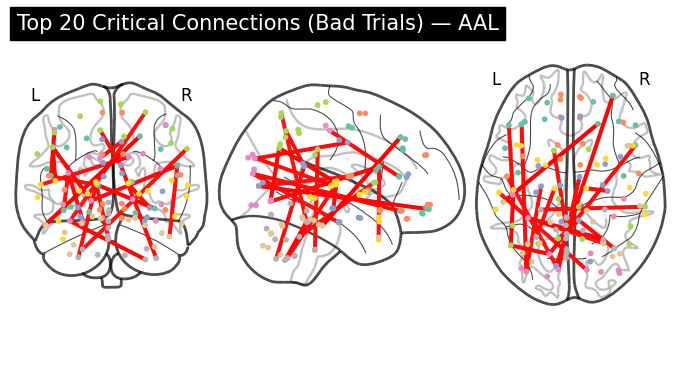

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_aal
from nilearn import plotting

# Parameters for AAL
num_nodes    = 116
num_features = num_nodes * (num_nodes - 1) // 2  # = 116*115/2 = 6670 total edges
top_k        = 20  # how many top edges to show

# Load the selected edge indices and accuracy per trial
selected_indices = np.load('selected_indices_aal(500t-corr).npy')  # (num_selected, num_trials)
accuracy_vector  = np.load('accuracy_vector_aal(500t-corr).npy')   # (num_trials,)

# Find all trials where accuracy is below the median (bad trials) as well as the bad indices
indices_matrix = selected_indices.T  # shape: (num_trials, num_selected)
median_acc     = np.median(accuracy_vector)
bad_trials     = indices_matrix[accuracy_vector < median_acc]
bad_indices    = bad_trials.flatten() if bad_trials.size > 0 else np.array([], dtype=int)

# Count how often each edge appears in bad trials
freq_bad = np.bincount(bad_indices, minlength=num_features)

# Pick the top_k edges that appear most often in bad trials
top_bad_idx = np.argsort(freq_bad)[-top_k:][::-1]

# Helper to convert a flat edge index k to (i,j) in a n*n matrix
def index_to_coords(k, n=num_nodes):
    total = 0
    for i in range(n - 1):
        count = n - i - 1
        if k < total + count:
            j = i + 1 + (k - total)
            return i, j
        total += count
    raise ValueError("Index out of range.")

# Build a symmetric “frequency” matrix for those critical edges
matrix_critical = np.zeros((num_nodes, num_nodes))
for idx in top_bad_idx:
    i, j = index_to_coords(int(idx))
    matrix_critical[i, j] = freq_bad[idx]
    matrix_critical[j, i] = freq_bad[idx]

# Fetch AAL centroids for plotting
aal = fetch_atlas_aal()           
coords = plotting.find_parcellation_cut_coords(aal.maps)  # (116, 3)

# Plot only those critical connections on a glass brain
threshold = freq_bad[top_bad_idx[-1]]  # lowest frequency among the chosen edges
display = plotting.plot_connectome(
    matrix_critical,
    coords,
    edge_threshold=threshold,
    node_size=10,
    title=f"Top {top_k} Critical Connections (Bad Trials) — AAL"
)

plt.show()

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/aal_SPM12

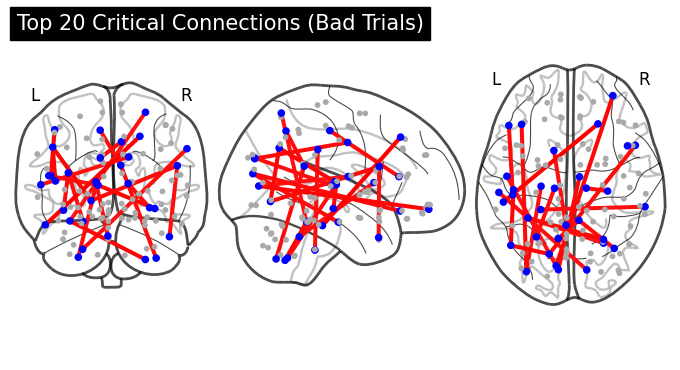

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/aal_SPM12

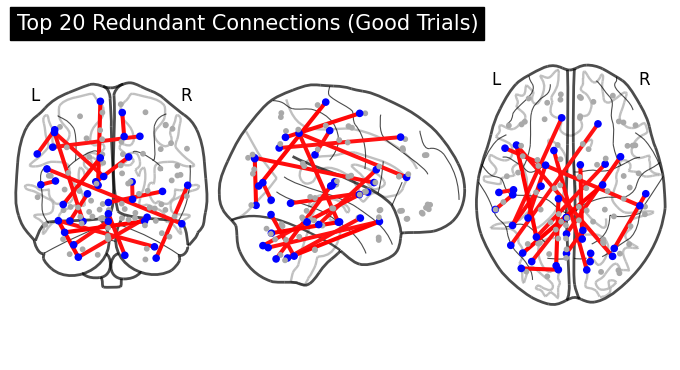

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_aal
from nilearn import plotting

# Parameters for AAL
num_nodes    = 116
num_features = num_nodes * (num_nodes - 1) // 2  
top_k        = 20      # edges per category

# Load trial data
selected_indices = np.load('selected_indices_aal(500t-corr).npy')  # shape: (num_selected, num_trials)
accuracy_vector  = np.load('accuracy_vector_aal(500t-corr).npy')   # shape: (num_trials,)

# Prepare split by median accuracy
indices_matrix = selected_indices.T                 # (num_trials, num_selected)
median_acc     = np.median(accuracy_vector)

# Bad trials / critical edges
bad_trials     = accuracy_vector < median_acc
bad_indices  = indices_matrix[bad_trials].flatten() if bad_trials.any() else np.array([], dtype=int)
freq_bad     = np.bincount(bad_indices, minlength=num_features)
top_bad_idx  = np.argsort(freq_bad)[-top_k:][::-1]

# Good trials / redundant edges
good_trials     = accuracy_vector >= median_acc
good_indices  = indices_matrix[good_trials].flatten() if good_trials.any() else np.array([], dtype=int)
freq_good     = np.bincount(good_indices, minlength=num_features)
top_good_idx  = np.argsort(freq_good)[-top_k:][::-1]

# Index→(i,j) helper for upper‐triangle of an n×n matrix
def index_to_coords(k, n=num_nodes):
    tot = 0
    for i in range(n - 1):
        cnt = n - i - 1
        if k < tot + cnt:
            return i, i + 1 + (k - tot)
        tot += cnt
    raise ValueError(f"Index {k} out of range")

# Plotting helper
def plot_edges(edge_idx_list, freq_arr, title):
    # build full symmetric weight matrix
    M = np.zeros((num_nodes, num_nodes))
    connected = np.zeros(num_nodes, bool)
    for k in edge_idx_list:
        i, j = index_to_coords(int(k))
        M[i, j] = freq_arr[k]
        M[j, i] = freq_arr[k]
        connected[[i, j]] = True

    # node styling
    node_sizes  = [20 if c else 10 for c in connected]
    node_colors = ['blue' if c else 'darkgray' for c in connected]

    # fetch AAL centroids
    aal = fetch_atlas_aal()
    coords = plotting.find_parcellation_cut_coords(aal.maps)

    # edge threshold = smallest of the top‐K freqs
    thresh = float(freq_arr[edge_idx_list[-1]])
    plotting.plot_connectome(
        M, coords,
        edge_threshold=thresh,
        node_size=node_sizes,
        node_color=node_colors,
        title=title
    )
    plt.show()

# Visualize both panels
plot_edges(top_bad_idx,  freq_bad,  f"Top {top_k} Critical Connections (Bad Trials)")
plot_edges(top_good_idx, freq_good, f"Top {top_k} Redundant Connections (Good Trials)")

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/aal_SPM12

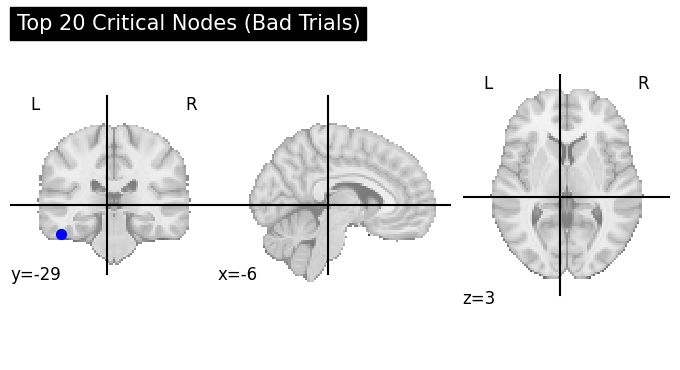

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/aal_SPM12

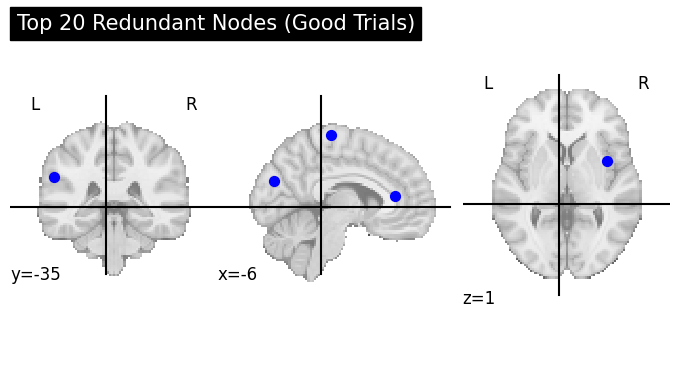

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_aal
from nilearn import plotting

# Parameters for AAL
num_nodes    = 116
num_features = num_nodes * (num_nodes - 1) // 2  
top_k        = 20

# Load trial data
selected_indices = np.load('selected_indices_aal(500t-corr).npy')  # (num_selected, num_trials)
accuracy_vector  = np.load('accuracy_vector_aal(500t-corr).npy')   # (num_trials,)

# Prepare median split
indices_matrix = selected_indices.T                 # (num_trials, num_selected)
median_acc     = np.median(accuracy_vector)

bad_trials  = indices_matrix[accuracy_vector < median_acc]
bad_indices = bad_trials.flatten() if bad_trials.size > 0 else np.array([], dtype=int)
freq_bad    = np.bincount(bad_indices, minlength=num_features)
top_bad_idx = np.argsort(freq_bad)[-top_k:][::-1]

good_trials  = indices_matrix[accuracy_vector >= median_acc]
good_indices = good_trials.flatten() if good_trials.size > 0 else np.array([], dtype=int)
freq_good    = np.bincount(good_indices, minlength=num_features)
top_good_idx = np.argsort(freq_good)[-top_k:][::-1]

#  Map 1D edge-index → (i, j) in the n×n matrix 
def index_to_coords(k, n=num_nodes):
    total = 0
    for i in range(n - 1):
        count = n - i - 1
        if k < total + count:
            return i, i + 1 + (k - total)
        total += count
    raise ValueError(f"Index {k} out of range for n={n}.")

# Plot nodes on ortho slices centered on their centroid
def plot_nodes_ortho(edge_idx_list, title):
    # 1. Flag which nodes are involved
    connected = np.zeros(num_nodes, dtype=bool)
    for idx in edge_idx_list:
        i, j = index_to_coords(int(idx))
        connected[i] = True
        connected[j] = True

    # 2. Fetch AAL centroids
    aal   = fetch_atlas_aal()
    coords = plotting.find_parcellation_cut_coords(aal.maps)

    # 3. Extract only the active-node coords
    coords_active = np.array([coords[i] for i, flag in enumerate(connected) if flag])
    if coords_active.size == 0:
        print(f"No nodes to plot for: {title}")
        return

    # 4. Compute mean center
    center = tuple(coords_active.mean(axis=0))

    # 5. Plot the anatomical slices
    display = plotting.plot_anat(
        title=title,
        display_mode='ortho',
        cut_coords=center
    )

    # 6. Overlay markers at each active centroid
    display.add_markers(
        coords_active.tolist(),
        marker_color='blue',
        marker_size=50
    )
    plt.show()

# Visualize critical vs. redundant nodes
plot_nodes_ortho(top_bad_idx,  f"Top {top_k} Critical Nodes (Bad Trials)")
plot_nodes_ortho(top_good_idx, f"Top {top_k} Redundant Nodes (Good Trials)")

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/aal_SPM12

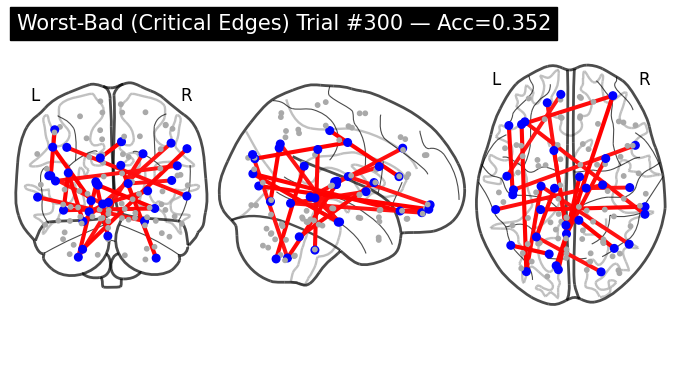

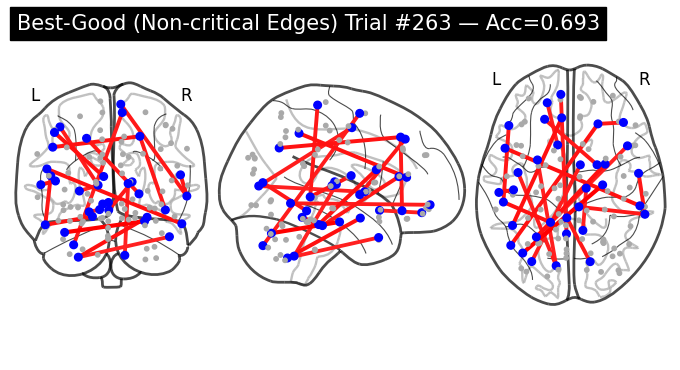

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_aal
from nilearn import plotting

# Load your trial data 
selected_indices = np.load('selected_indices_aal(500t-corr).npy')  # shape: (num_selected, num_trials)
accuracy_vector  = np.load('accuracy_vector_aal(500t-corr).npy')   # shape: (num_trials,)

# Parameters for AAL
num_nodes    = 116
num_features = num_nodes * (num_nodes - 1) // 2  
top_k        = 20

#  Split by median accuracy
median_acc = np.median(accuracy_vector)
all_trials = np.arange(len(accuracy_vector))

bad_trials  = accuracy_vector < median_acc
good_trials = accuracy_vector >= median_acc

# Identify the single worst (lowest‐acc) bad trial and best (highest‐acc) good trial
bad_trials = all_trials[bad_trials]
best_bad   = bad_trials[np.argmin(accuracy_vector[bad_trials])] if bad_trials.size else None

good_trials = all_trials[good_trials]
best_good   = good_trials[np.argmax(accuracy_vector[good_trials])] if good_trials.size else None

# Precompute global edge frequencies over bad vs. good sets
indices_matrix = selected_indices.T  # (num_trials, num_selected)
freq_bad  = np.bincount(indices_matrix[bad_trials].flatten(),  minlength=num_features)
freq_good = np.bincount(indices_matrix[good_trials].flatten(), minlength=num_features)

# Helper: map 1D edge‐index → (i,j) in the upper triangle of an n×n matrix
def index_to_coords(k, n=num_nodes):
    total = 0
    for i in range(n - 1):
        cnt = n - i - 1
        if k < total + cnt:
            return i, i + 1 + (k - total)
        total += cnt
    raise ValueError(f"Index {k} out of range for n={n}")

# Fetch AAL centroids once
aal    = fetch_atlas_aal()
coords  = plotting.find_parcellation_cut_coords(aal.maps)

def plot_top20(trial_idx, freq_array, label):
    if trial_idx is None:
        print(f"No {label} trials to plot.")
        return

    acc    = accuracy_vector[trial_idx]
    masked = selected_indices[:, trial_idx]   # which edges were zeroed in that trial

    # rank those edges by their overall freq, take top_k
    ranked = masked[np.argsort(freq_array[masked])[::-1]]
    top20   = ranked[:top_k]

    # build n×n adjacency with only those edges
    M = np.zeros((num_nodes, num_nodes))
    involved = np.zeros(num_nodes, bool)
    for k in top20:
        i, j = index_to_coords(int(k))
        M[i, j] = freq_array[int(k)]
        M[j, i] = freq_array[int(k)]
        involved[i] = True
        involved[j] = True

    # style nodes
    sizes  = [30 if involved[n] else 10 for n in range(num_nodes)]
    colors = ['blue' if involved[n] else 'darkgray' for n in range(num_nodes)]

    plotting.plot_connectome(
        M,
        coords,
        edge_threshold=min(freq_array[top20]),
        node_size=sizes,
        node_color=colors,
        title=f"{label} Trial #{trial_idx} — Acc={acc:.3f}"
    )
    plt.show()

# Plot the two panels
plot_top20(best_bad,  freq_bad,  "Worst-Bad (Critical Edges)")
plot_top20(best_good, freq_good, "Best-Good (Non-critical Edges)")

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/aal_SPM12

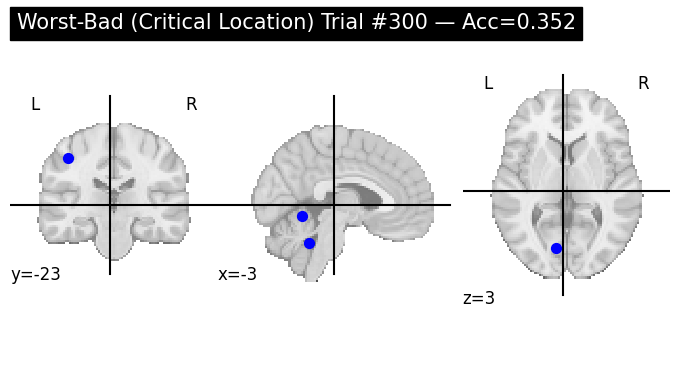

[get_dataset_dir] Dataset found in /Users/lade/nilearn_data/aal_SPM12

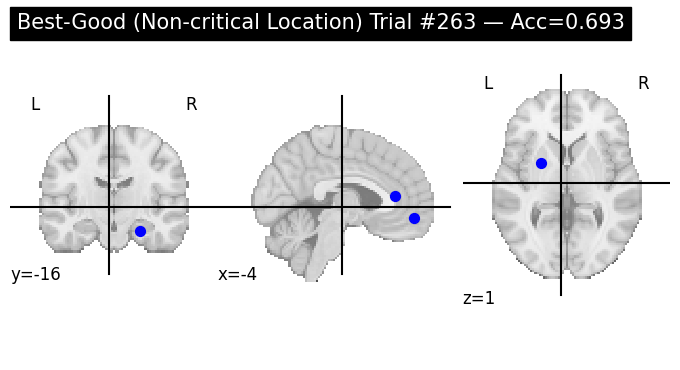

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn.datasets import fetch_atlas_aal
from nilearn import plotting

# Load your trial data
selected_indices = np.load('selected_indices_aal(500t-corr).npy')  # (num_selected, num_trials)
accuracy_vector  = np.load('accuracy_vector_aal(500t-corr).npy')   # (num_trials,)

# Parameters for AAL
num_nodes    = 116
num_features = num_nodes * (num_nodes - 1) // 2   
top_k        = 20

# Split by median accuracy
median_acc = np.median(accuracy_vector)
all_trials = np.arange(len(accuracy_vector))

bad_trials  = accuracy_vector < median_acc
good_trials = accuracy_vector >= median_acc

bad_trials  = all_trials[bad_trials]
best_bad    = bad_trials[np.argmin(accuracy_vector[bad_trials])] \
                if bad_trials.size else None

good_trials = all_trials[good_trials]
best_good   = good_trials[np.argmax(accuracy_vector[good_trials])] \
                if good_trials.size else None

# Global edge‐frequency maps
indices_matrix = selected_indices.T  # (num_trials, num_selected)
freq_bad  = np.bincount(indices_matrix[bad_trials].flatten(),  minlength=num_features)
freq_good = np.bincount(indices_matrix[good_trials].flatten(), minlength=num_features)

#  Helper: map 1D edge‐index → (i,j) in n×n upper triangle
def index_to_coords(k, n=num_nodes):
    total = 0
    for i in range(n - 1):
        cnt = n - i - 1
        if k < total + cnt:
            return i, i + 1 + (k - total)
        total += cnt
    raise ValueError(f"Index {k} out of range for n={n}")

# Ortho‐slice plotting for the top-20 edges of one trial
def plot_top20_ortho(trial_idx, freq_array, label):
    if trial_idx is None:
        print(f"No {label} trials to plot.")
        return
    acc    = accuracy_vector[trial_idx]
    masked = selected_indices[:, trial_idx]  # edges zeroed in this trial

    # rank this trial’s edges by their global freq, take top_k
    ranked = masked[np.argsort(freq_array[masked])[::-1]]
    top20   = ranked[:top_k]

    # mark which nodes get involved
    involved = np.zeros(num_nodes, dtype=bool)
    for k in top20:
        i, j = index_to_coords(int(k))
        involved[i] = True
        involved[j] = True

    # fetch AAL centroids
    aal   = fetch_atlas_aal()
    coords = plotting.find_parcellation_cut_coords(aal.maps)

    # select only the active-node coords
    coords_active = [coords[i] for i, flag in enumerate(involved) if flag]
    if not coords_active:
        print(f"No nodes to plot for {label} Trial #{trial_idx}")
        return

    # center the ortho view
    center = tuple(np.mean(coords_active, axis=0))

    # show the anatomy + markers
    display = plotting.plot_anat(
        title=f"{label} Trial #{trial_idx} — Acc={acc:.3f}",
        display_mode='ortho',
        cut_coords=center
    )
    display.add_markers(
        coords_active,
        marker_color='blue',
        marker_size=50
    )
    plt.show()

# Render both panels
plot_top20_ortho(best_bad,  freq_bad,  "Worst-Bad (Critical Location)")
plot_top20_ortho(best_good, freq_good, "Best-Good (Non-critical Location)")

In [ ]:
#End

In [29]:
import numpy as np
import torch
from torch_geometric.data import Data, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

In [30]:
# Model definition
class GraphAttentionModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super(GraphAttentionModel, self).__init__()
        self.gat1 = GATv2Conv(input_dim, hidden_dim, heads=heads, dropout=0.3, edge_dim=1)
        self.gat2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=heads, dropout=0.3, edge_dim=1)
        self.gat3 = GATv2Conv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=0.3, edge_dim=1)
        self.fc = torch.nn.Linear(output_dim, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        ew = edge_weight.view(-1, 1)
        x = F.relu(self.gat1(x, edge_index, ew))
        x = F.relu(self.gat2(x, edge_index, ew))
        x = self.gat3(x, edge_index, ew)
        x = global_mean_pool(x, batch)
        return torch.sigmoid(self.fc(x))

In [31]:
# Train, validation, evaluation

def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_weight, data.batch)
        loss = criterion(out.squeeze(1), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_loss(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    total_graphs = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.edge_weight, data.batch)
            loss = criterion(out.squeeze(1), data.y.float())
            total_loss += loss.item() * data.num_graphs
            total_graphs += data.num_graphs
    return total_loss / total_graphs

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.edge_weight, data.batch)
            pred = (out.squeeze(1) > 0.5).float()
            correct += (pred == data.y).sum().item()
            total += data.num_graphs
    return correct / total

In [37]:
# Load data
x = np.load('./AtlasGNNinput/AAL_correlation_correlation.npy')
y = np.load('./AtlasGNNinput/Y.npy')
accuracy_vector = np.load("accuracy_vector_aal(500t-corr).npy")
selected_indices = np.load("selected_indices_aal(500t-corr).npy")

best_trial_index = np.argmax(accuracy_vector)
best_selected_indices = selected_indices[:, best_trial_index]


print("Best trial index:", best_trial_index)
print("Best accuracy:", accuracy_vector[best_trial_index])
# print("First 10 selected edge indices:", best_selected_indices[:10])

Best trial index: 263
Best accuracy: 0.6931818181818182


In [43]:
len(best_selected_indices)

1334

In [38]:
num_graphs, num_nodes, _ = x.shape
edge_pairs = [(i, j) for i in range(num_nodes) for j in range(i + 1, num_nodes)]

In [39]:
def generate_selected_graphs(X, y, selected_edge_indices):
    graphs = []
    for graph_idx in range(X.shape[0]):
        adjacency_matrix = X[graph_idx]
        label = y[graph_idx]
        node_features = [[1.0] for _ in range(num_nodes)]
        edge_index = []
        edge_weight = []

        for idx in selected_edge_indices:
            i, j = edge_pairs[idx]
            weight = adjacency_matrix[i, j]
            if weight != 0:
                edge_index.append([i, j])
                edge_weight.append(weight)
                node_features[i][0] += weight
                node_features[j][0] += weight

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous() if edge_index else torch.empty((2, 0), dtype=torch.long)
        edge_weight = torch.tensor(edge_weight, dtype=torch.float)
        node_features = torch.tensor(node_features, dtype=torch.float)
        label_tensor = torch.tensor(label, dtype=torch.float)

        data = Data(x=node_features, edge_index=edge_index, edge_weight=edge_weight, y=label_tensor)
        graphs.append(data)
    return graphs

selected_graphs = generate_selected_graphs(x, y, best_selected_indices)

In [40]:
# 10-fold cross-validation with inner stratified split
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
test_accuracies = []

for fold, (train_val_idx, test_idx) in enumerate(skf.split(selected_graphs, y)):
    train_val_y = y[train_val_idx]
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=fold)
    inner_train_idx, val_idx = next(sss.split(train_val_idx, train_val_y))
    train_idx = train_val_idx[inner_train_idx]
    val_idx = train_val_idx[val_idx]

    train_loader = DataLoader([selected_graphs[i] for i in train_idx], batch_size=32, shuffle=True)
    val_loader = DataLoader([selected_graphs[i] for i in val_idx], batch_size=32)
    test_loader = DataLoader([selected_graphs[i] for i in test_idx], batch_size=32)

    model = GraphAttentionModel(input_dim=1, hidden_dim=16, output_dim=2, heads=4)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.BCELoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)

    for epoch in range(30):
        train_loss = train(model, train_loader, optimizer, criterion)
        val_loss = eval_loss(model, val_loader, criterion)
        scheduler.step(val_loss)

    test_acc = evaluate(model, test_loader)
    test_accuracies.append(test_acc)
    print(f"Fold {fold+1}: Test Accuracy = {test_acc:.4f}")

mean_acc = np.mean(test_accuracies)
std_acc = np.std(test_accuracies)
print(f"\nAverage Test Accuracy over 10 folds: {mean_acc:.4f} ± {std_acc:.4f}")

/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 1: Test Accuracy = 0.4886


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 2: Test Accuracy = 0.5287


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 3: Test Accuracy = 0.5287


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 4: Test Accuracy = 0.5287


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 5: Test Accuracy = 0.5402


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 6: Test Accuracy = 0.5632


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 7: Test Accuracy = 0.5287


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 8: Test Accuracy = 0.5402


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 9: Test Accuracy = 0.5287


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Fold 10: Test Accuracy = 0.5172

Average Test Accuracy over 10 folds: 0.5293 ± 0.0179


In [46]:
import numpy as np
import torch
from torch_geometric.data import Data, DataLoader
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_mean_pool
from sklearn.model_selection import StratifiedKFold

# Define model
class GraphAttentionModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        super(GraphAttentionModel, self).__init__()
        self.gat1 = GATv2Conv(input_dim, hidden_dim, heads=heads, dropout=0.3, edge_dim=1)
        self.gat2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=heads, dropout=0.3, edge_dim=1)
        self.gat3 = GATv2Conv(hidden_dim * heads, output_dim, heads=1, concat=False, dropout=0.3, edge_dim=1)
        self.fc = torch.nn.Linear(output_dim, 1)

    def forward(self, x, edge_index, edge_weight, batch):
        ew = edge_weight.view(-1, 1)
        x = F.relu(self.gat1(x, edge_index, ew))
        x = F.relu(self.gat2(x, edge_index, ew))
        x = self.gat3(x, edge_index, ew)
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return torch.sigmoid(x)

# Training function
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for data in loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_weight, data.batch)
        loss = criterion(out.squeeze(1), data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation accuracy
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index, data.edge_weight, data.batch)
            pred = (out.squeeze(1) > 0.5).float()
            correct += (pred == data.y).sum().item()
            total += data.num_graphs
    return correct / total

# Load data
x = np.load('./AtlasGNNinput/AAL_correlation_correlation.npy')  # shape: (871, 116, 116)
y = np.load('./AtlasGNNinput/Y.npy')  # shape: (871,)

accuracy_vector = np.load("accuracy_vector_aal(500t-corr).npy")
selected_indices = np.load("selected_indices_aal(500t-corr).npy")

best_trial_index = np.argmax(accuracy_vector)
best_selected_indices = selected_indices[:, best_trial_index]

print("Best trial index:", best_trial_index)
print("Best accuracy:", accuracy_vector[best_trial_index])

num_graphs, num_nodes, _ = x.shape
edge_pairs = [(i, j) for i in range(num_nodes) for j in range(i + 1, num_nodes)]

# Generate graphs using only selected edges
def generate_selected_graphs(X, y, selected_edge_indices):
    graphs = []
    for graph_idx in range(X.shape[0]):
        adjacency_matrix = X[graph_idx]
        label = y[graph_idx]
        node_features = [[1.0] for _ in range(num_nodes)]
        edge_index = []
        edge_weight = []

        for idx in selected_edge_indices:
            i, j = edge_pairs[idx]
            weight = adjacency_matrix[i, j]
            if weight != 0:
                edge_index.append([i, j])
                edge_weight.append(weight)
                node_features[i][0] += weight
                node_features[j][0] += weight

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous() if edge_index else torch.empty((2, 0), dtype=torch.long)
        edge_weight = torch.tensor(edge_weight, dtype=torch.float)
        node_features = torch.tensor(node_features, dtype=torch.float)
        label_tensor = torch.tensor(label, dtype=torch.float)

        data = Data(x=node_features, edge_index=edge_index, edge_weight=edge_weight, y=label_tensor)
        graphs.append(data)
    return graphs

# Generate graph data
selected_graphs = generate_selected_graphs(x, y, best_selected_indices)
graph_labels = y

# Cross-validation loop (stratified 10-fold)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
test_accuracies = []

for fold, (train_idx, test_idx) in enumerate(skf.split(selected_graphs, graph_labels)):
    train_subset = [selected_graphs[i] for i in train_idx]
    test_subset = [selected_graphs[i] for i in test_idx]

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=32)

    model = GraphAttentionModel(input_dim=1, hidden_dim=32, output_dim=2, heads=4)
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train for 30 epochs
    for epoch in range(30):
        train_loss = train(model, train_loader, optimizer, criterion)

    test_acc = evaluate(model, test_loader)
    test_accuracies.append(test_acc)
    print(f"Fold {fold+1}: Test Accuracy = {test_acc:.4f}")

# Final mean and std
mean_acc = np.mean(test_accuracies)
std_acc = np.std(test_accuracies)
print(f"\nAverage Test Accuracy over 10 folds: {mean_acc:.4f} ± {std_acc:.4f}")

Best trial index: 263
Best accuracy: 0.6931818181818182


/Users/lade/anaconda3/envs/research/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 1: Test Accuracy = 0.5000
Fold 2: Test Accuracy = 0.5172
Fold 3: Test Accuracy = 0.5287
Fold 4: Test Accuracy = 0.5747
Fold 5: Test Accuracy = 0.5402
Fold 6: Test Accuracy = 0.5747
Fold 7: Test Accuracy = 0.5402
Fold 8: Test Accuracy = 0.5747
Fold 9: Test Accuracy = 0.5862
Fold 10: Test Accuracy = 0.5172

Average Test Accuracy over 10 folds: 0.5454 ± 0.0287
